In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt 
import numpy as np

from tqdm.notebook import tqdm

In [2]:
#Step 1: creating dataset
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)#handles label creation, class names for imgs
        
    def __len__(self): #to let dataloader know len of data
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    @property
    def classes(self):
        return self.data.classes

In [3]:
#testing read with train data
data_dir='C:/Users/hanso/Desktop/projects_desktop/pytorchLearning/playingcardsDataset/train'
dataset = PlayingCardDataset(data_dir)

In [4]:
len(dataset)

7624

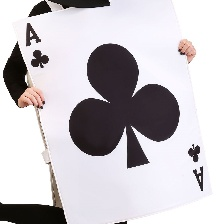

In [5]:
image, label = dataset[0]
image

In [6]:
#create dictionary linking label to class(folder) names
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
#standarize input size with transform
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
#Step 2: dataloader: batching and shuffling
valid_data_dir = 'C:/Users/hanso/Desktop/projects_desktop/pytorchLearning/playingcardsDataset/valid'
test_data_dir = 'C:/Users/hanso/Desktop/projects_desktop/pytorchLearning/playingcardsDataset/test'

train_dataset =PlayingCardDataset(data_dir, transform)
valid_dataset =PlayingCardDataset(valid_data_dir, transform)
test_dataset =PlayingCardDataset(test_data_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)#only need to shuffle train data
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
#examine transformed image that is now pytorch tensor
image, label = train_dataset[2]
image.shape

torch.Size([3, 128, 128])

In [22]:
#examine image dimensionality
for images, labels in train_loader:
    break

In [23]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [24]:
#Step 3: pytorch Model
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53): #defining parts of model
        super(SimpleCardClassifier, self).__init__() #initalize from parent class
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True) #using pretrained efficientnet
        #removing additional layer we don't need so we can use our own classifier
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280 #feature size output by model. Need to resize to num_classes=53
        #classifier to resize feature output size
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x): #connect parts of model, run the model
        x = self.features(x) #x is input of batches of examples, get features
        output = self.classifier(x) #classifier used on features
        return output

In [25]:
model = SimpleCardClassifier(num_classes=53)

In [26]:
#examine model
print(model)

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, ke

In [27]:
#testing model working correctly with input
example_out = model(images)
example_out.shape #[batch_size, num_classes]

torch.Size([32, 53])

In [28]:
#Step 4: training loop
#feed data into model by batches, apply loss function

#loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [29]:
# test loss function
criterion(example_out, labels)

tensor(3.9840, grad_fn=<NllLossBackward0>)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #using gpu
print(device)

cuda:0


In [37]:
num_epochs = 5
train_losses, val_losses = [], []

model.to(device)#model train on gpu if present
for epoch in range(num_epochs):
    #set model to train:
    model.train()
    #keep tracking of running loss:
    running_loss = 0.0
    for images, labels in train_loader: #wrap tqdm around loader to get progress bars 
        images, labels = images.to(device), labels.to(device) #sending to gpu
        optimizer.zero_grad() #zero the gradient to prevent accumulation from prev runs
        outputs = model(images) #forward pass to model
        loss = criterion(outputs, labels) #calc loss
        loss.backward() #apply backprop
        optimizer.step() #update model weights/params
        running_loss+=loss.item()*images.size(0)
    train_loss = running_loss/len(train_loader.dataset)
    train_losses.append(train_loss) #push onto train losses list

    #model validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad(): #ensures weights are not changed
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) #sending to gpu
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()*images.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    #printing epochs status
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Valid loss: {val_loss}")

Epoch 1/5 - Train loss: 0.5913481590380073, Valid loss: 0.20517820322288657
Epoch 2/5 - Train loss: 0.35188951997666895, Valid loss: 0.2189760203631419
Epoch 3/5 - Train loss: 0.23356351197735334, Valid loss: 0.15359229839073038
Epoch 4/5 - Train loss: 0.19130576697470383, Valid loss: 0.15586584536534434
Epoch 5/5 - Train loss: 0.1752207058893296, Valid loss: 0.1457873305059829


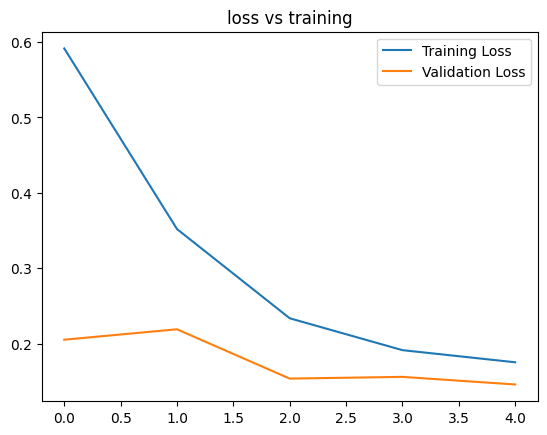

In [38]:
#visualize training progress:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("loss vs training")
plt.show()

In [40]:
# result evals:
model.eval()  # Set the model to evaluation mode
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1) #torch.max first return val is max val of dim 1, second val is index of max val
        
        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        
        # Count total predictions
        total_predictions += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 96.98%
